### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


### Read in MNIST Data

In [2]:
data = input_data.read_data_sets("data/MNIST", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print("Data shapes:")
print("Train - x:{}, y:{}".format(data.train.images.shape, data.train.labels.shape))
print("Test - x:{}, y:{}".format(data.test.images.shape, data.test.labels.shape))
print("Validation - x:{}, y:{}".format(data.validation.images.shape, data.validation.labels.shape))

Data shapes:
Train - x:(55000, 784), y:(55000, 10)
Test - x:(10000, 784), y:(10000, 10)
Validation - x:(5000, 784), y:(5000, 10)


### One-Hot Encoding

In [4]:
data.test.labels[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [5]:
data.test.cls = np.asarray([label.argmax() for label in data.test.labels])
data.test.cls[:5]

array([7, 2, 1, 0, 4])

### Particulars of dataset

In [6]:
img_size = 28
img_shape = (img_size, img_size)
img_size_flat = img_size * img_size
num_classes = 10

### Visualize Dataset

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


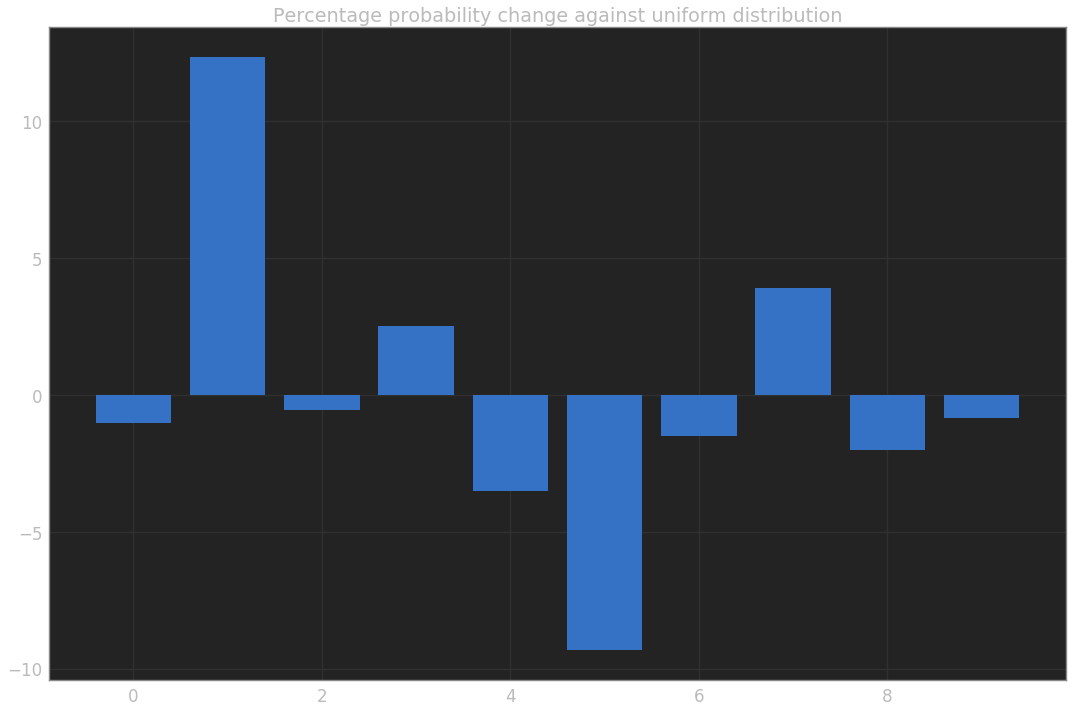

In [7]:
plt.bar(range(num_classes), data.train.labels.sum(axis=0) / data.train.labels.shape[0] * num_classes * 100.0 - 100.0)
plt.title("Percentage probability change against uniform distribution")

### View some sample images

#### Helper function to plot images

In [128]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    # Plots first 9 images
    fig, axes = plt.subplots(3, 3)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i].reshape(img_shape), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if cls_pred is None:
            ax.set_xlabel("True: {}".format(cls_true[i]))
        else:
            ax.set_xlabel("True: {}, Predicted:{}".format(cls_true[i], cls_pred[i]))
            
        if not title is None:
            ax.set_title(title[i])

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


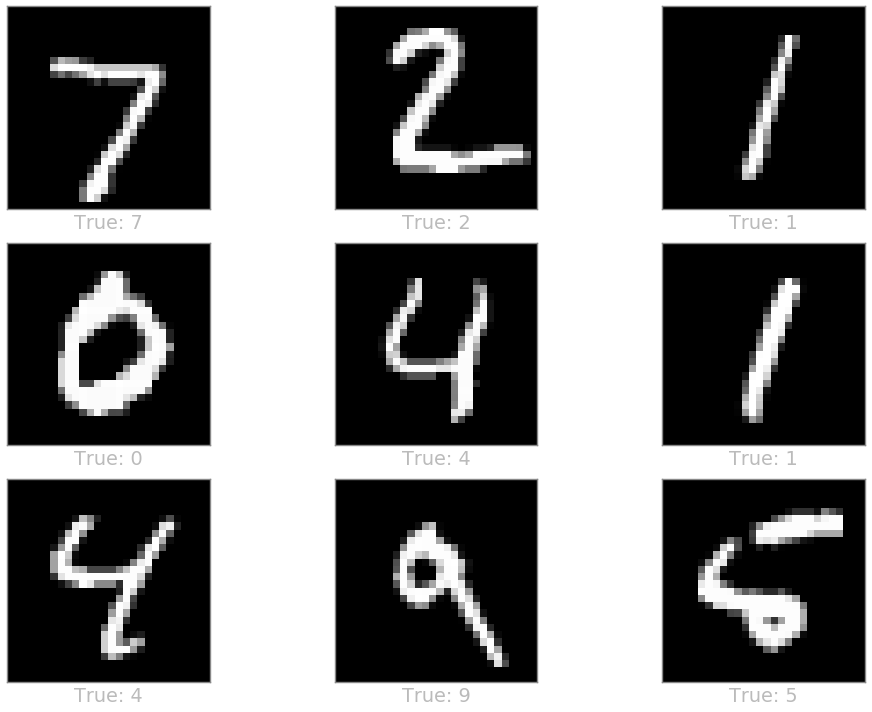

In [129]:
plot_images(data.test.images[:9], data.test.cls[:9])

### Define Tensorflow Graph

#### Placeholders for input data

In [10]:
x = tf.placeholder(tf.float32, (None, img_size_flat))
y_true_cls = tf.placeholder(tf.int64, (None))

#### Variables for parameters

In [11]:
weights = tf.Variable(tf.zeros((img_size_flat, num_classes)))
biases = tf.Variable(tf.zeros((num_classes)))

#### Model

In [12]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

#### Loss function to be optimized

In [13]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_cls, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#### Optimizer

In [95]:
optimizer = tf.train.MomentumOptimizer(0.5, 0.9).minimize(loss)

#### Helper function for iterating through optimization

In [96]:
batch_size = 100
def optimize(num_iterations=1):
    # Get the next batch of training examples
    for _ in range(num_iterations):
        x_batch, y_batch = data.train.next_batch(batch_size)

        y_batch_cls = np.array([label.argmax() for label in y_batch])
        # Create a feed dictionary to feed the session
        feed_dict_train = {x: x_batch, y_true_cls: y_batch_cls}

        # Pass it to the session
        session.run(optimizer, feed_dict_train)

### Metrics for evaluation

In [16]:
correctness = tf.equal(y_true_cls, y_pred_cls)
accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32))

#### Helper function for evaluating test accuracy

In [17]:
feed_dict_test = {x: data.test.images,
                 y_true_cls: data.test.cls}

In [31]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict_test)
    print("Accuracy: {0:.1%}".format(acc))

### Helper functions for visualization

In [130]:
def plot_incorrect_examples():
    scores, cls_pred = session.run([y_pred, y_pred_cls], feed_dict_test)
    
    incorrect = (cls_pred != data.test.cls)
    
    images = data.test.images[incorrect]
    cls_true = data.test.cls[incorrect]
    scores = scores[incorrect]
    scores = scores.max(axis=1)
    
    plot_images(images[:9], cls_true[:9], cls_pred[:9], title=scores[:9].round(2) * 100)

In [47]:
def plot_weights():
    w = session.run(weights)
    w_min = w.min()
    w_max = w.max()
    
    fig, axes = plt.subplots(2, 5)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.imshow(w[:, i].reshape(img_shape), cmap='seismic', vmin=w_min, vmax=w_max)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(i)

In [79]:
def print_confusion_matrix(zero_true=False):
    cls_pred = session.run(y_pred_cls, feed_dict_test)
    cm = confusion_matrix(data.test.cls, cls_pred, labels=range(num_classes))
    
    print(cm)
    
    if zero_true:
        cm[range(num_classes), range(num_classes)] = 0
        
    plt.imshow(cm, cmap=plt.cm.Reds, interpolation='nearest')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks, rotation=45)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.grid(False)
    plt.show()

### Run session

In [22]:
session = tf.Session()

#### Initialize variables

In [119]:
session.run(tf.global_variables_initializer())

### Initial Performace

In [32]:
print_accuracy()

Accuracy: 9.8%


/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


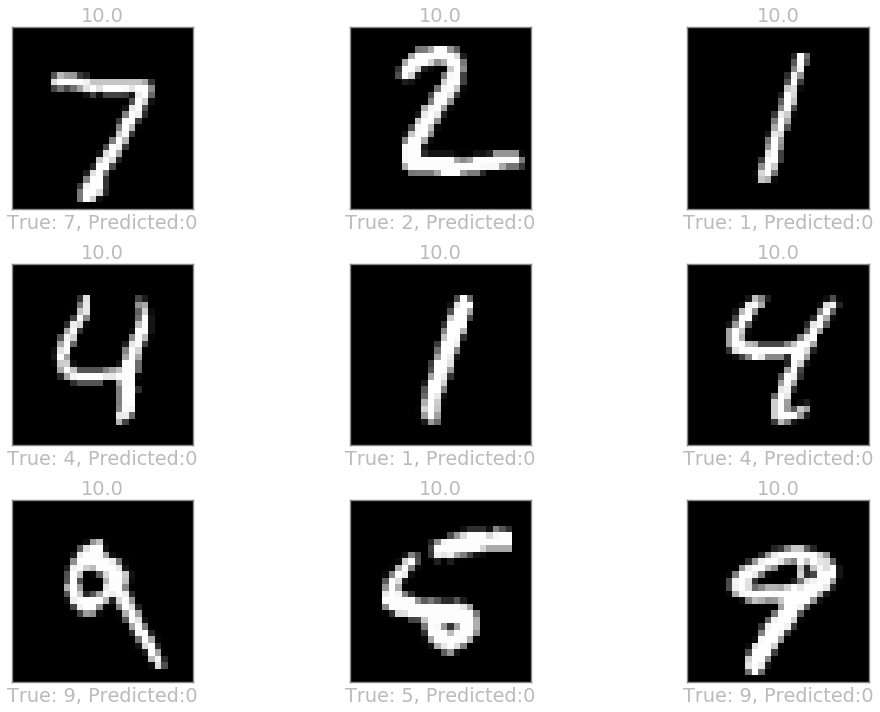

In [45]:
plot_incorrect_examples()

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


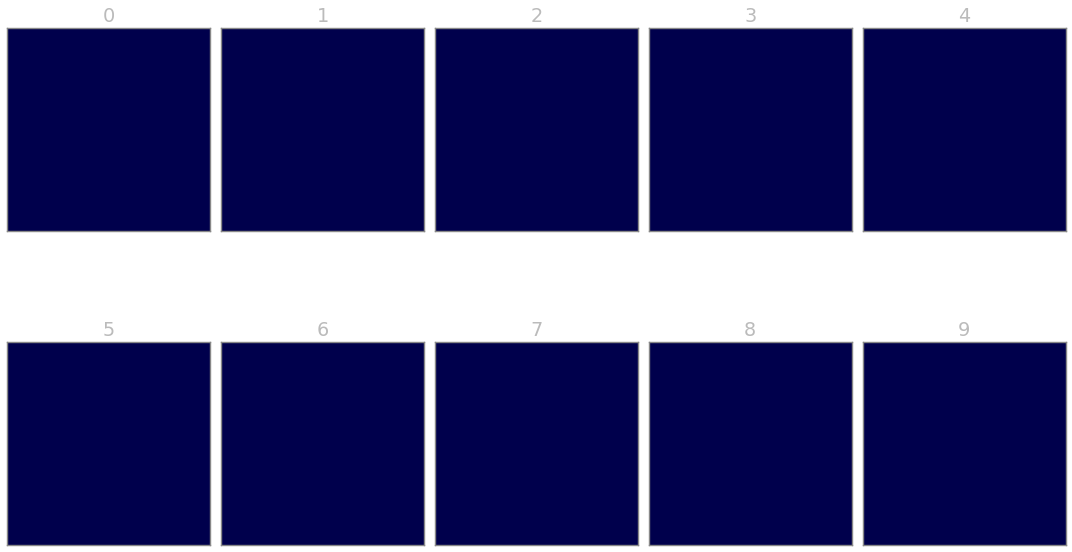

In [48]:
plot_weights()

### Performance after 1 iteration

In [121]:
optimize()

In [122]:
print_accuracy()

Accuracy: 45.5%


/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


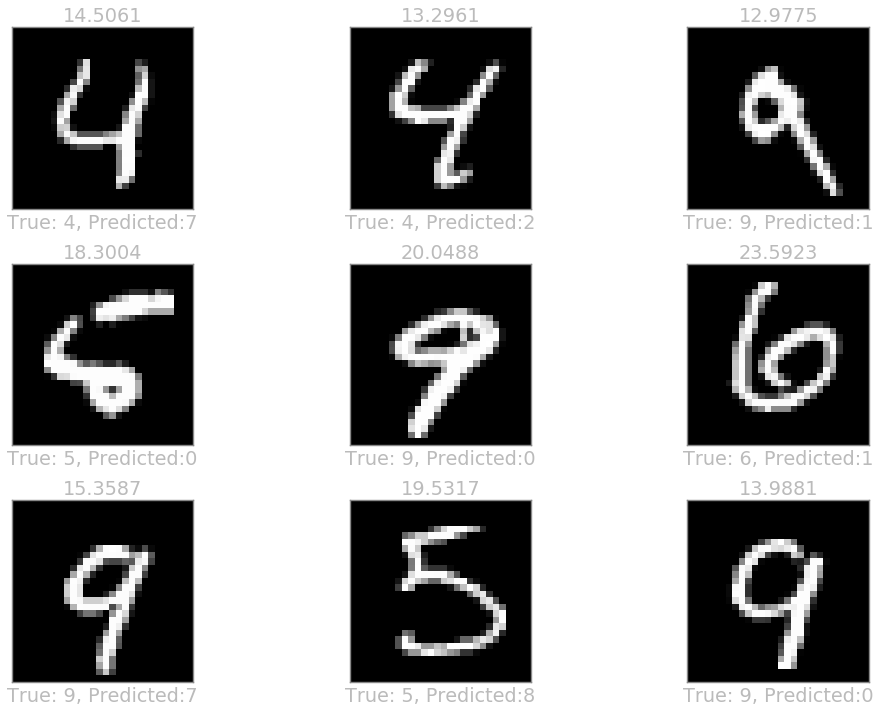

In [123]:
plot_incorrect_examples()

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


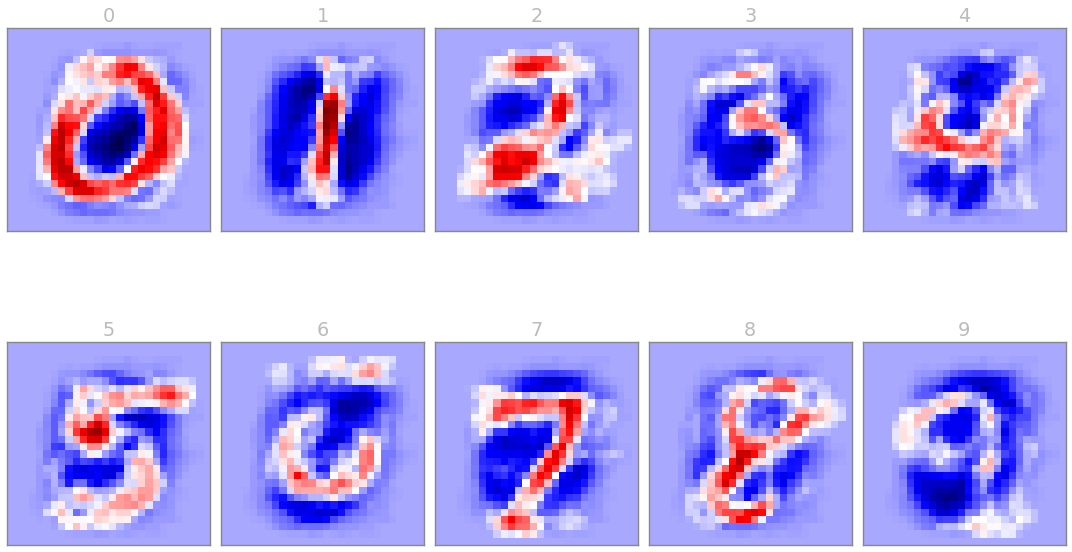

In [124]:
plot_weights()

### Performance after 10 iterations

In [102]:
optimize(9)

In [103]:
print_accuracy()

Accuracy: 81.2%


/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


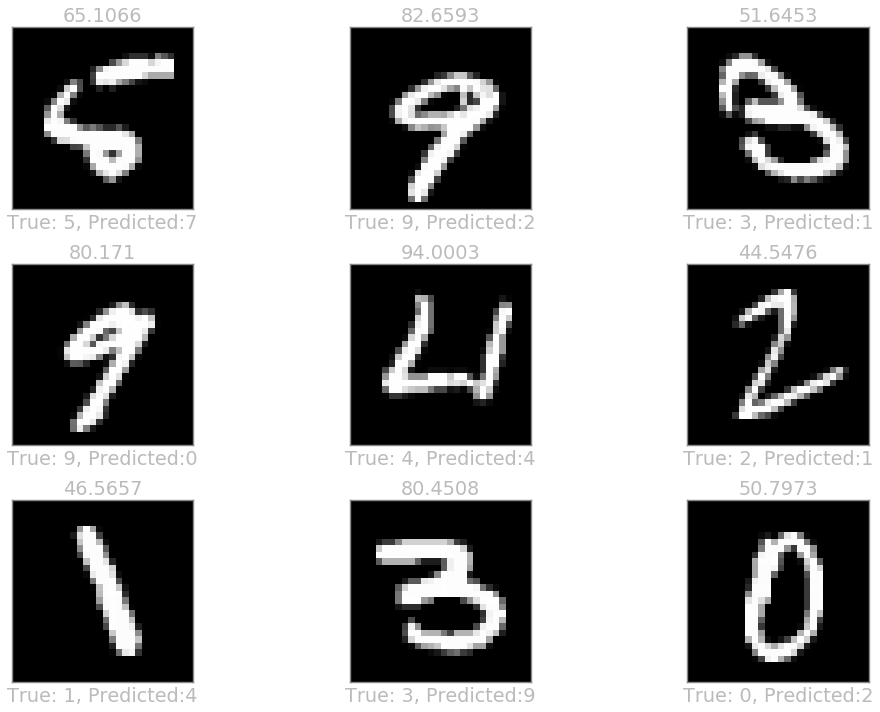

In [104]:
plot_incorrect_examples()

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


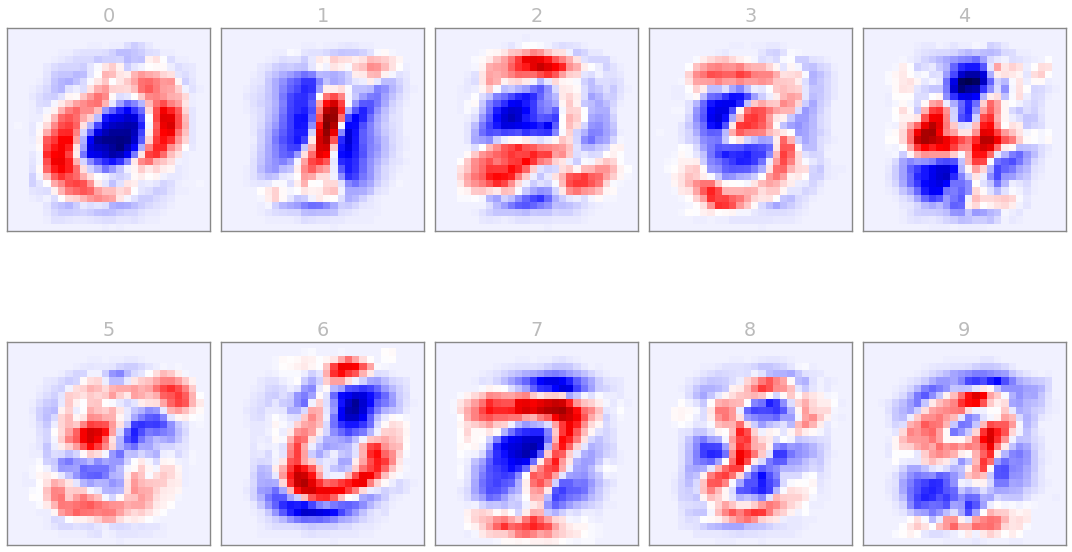

In [105]:
plot_weights()

### Performance after 1000 iterations

In [126]:
optimize(990)

In [107]:
print_accuracy()

Accuracy: 91.0%


/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


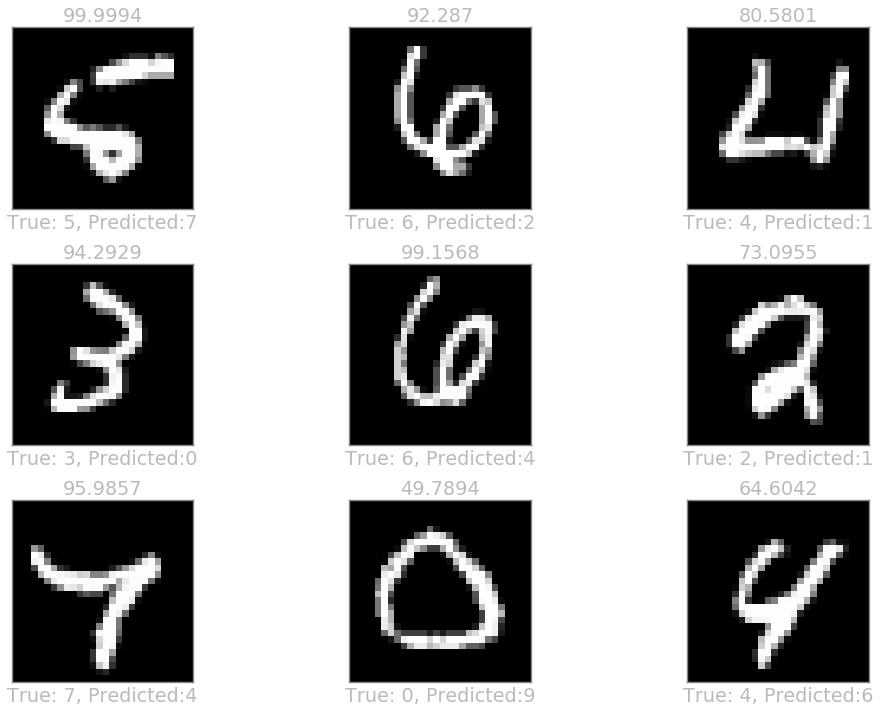

In [108]:
plot_incorrect_examples()

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


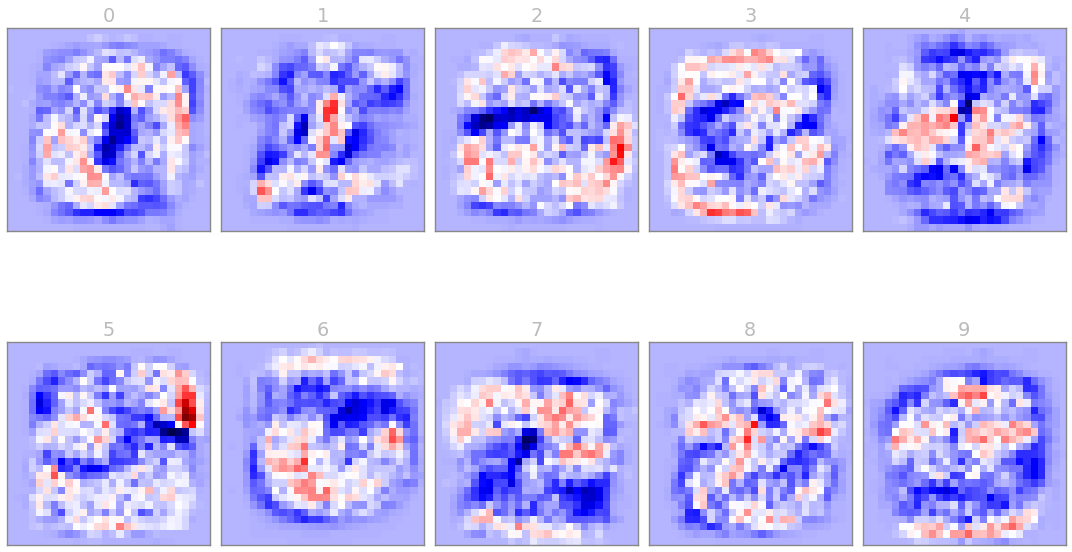

In [109]:
plot_weights()

### Confusion matrix

[[ 932    0    4    4    2    8   19    3    6    2]
 [   0 1091    1    3    1    5    5    2   25    2]
 [   4    9  927   16    9    4   18   12   27    6]
 [   1    2   17  920    2   14    5    9   25   15]
 [   1    2    3    1  890    0   25    6   13   41]
 [   5    2    8   62    7  682   24    6   81   15]
 [   4    3    4    1   17    9  915    1    4    0]
 [   0    7   14    6   13    2    0  932    6   48]
 [   4    4    7   26    7   12   12    9  876   17]
 [   7    4    1    9   23    3    0   17   14  931]]


/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


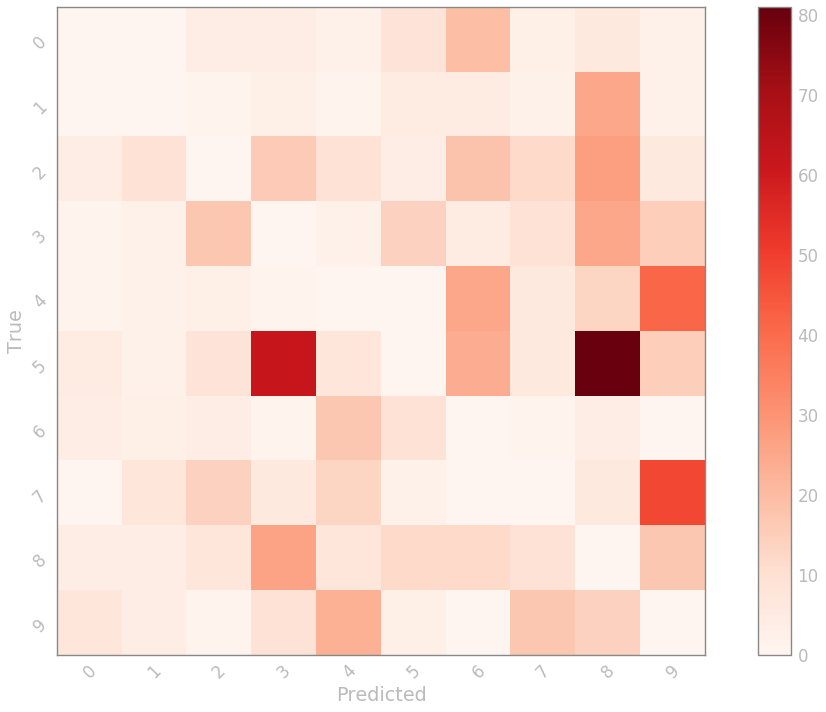

In [111]:
print_confusion_matrix(zero_true=True)

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


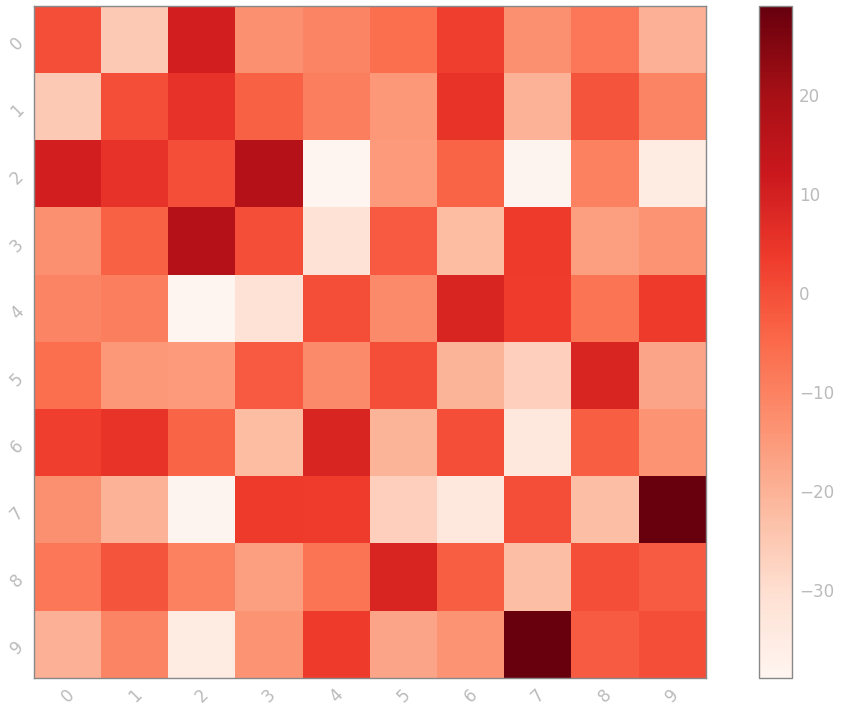

In [127]:
similarity_matrix = np.zeros((num_classes, num_classes))
w = session.run(weights)
for i in range(num_classes):
    for j in range(num_classes):
        similarity_matrix[i, j] = (w[:, i] * w[:, j]).sum()

similarity_matrix[range(num_classes), range(num_classes)] = 0

plt.imshow(similarity_matrix, cmap=plt.cm.Reds, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, rotation=45)
plt.yticks(tick_marks, rotation=45)
plt.grid(False)
plt.show()

### Close session

In [131]:
session.close()